<a href="https://colab.research.google.com/github/ANIRVANJENA/ANIRVANJENA/blob/main/Heston_volatility_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from eod import EodHistoricalData
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

# New section

In [ ]:
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    # constants
    a = kappa * theta
    b = kappa + lambd

    # common terms w.r.t phi
    rspi = rho * sigma * phi * 1j

    # define d parameter given phi and b
    d = np.sqrt((rho * sigma * phi * 1j - b)**2 + (phi * 1j + phi**2) * sigma**2)

    # define g parameter given phi, b and d
    g = (b - rspi + d) / (b - rspi - d)

    # calculate characteristic function by components
    exp1 = np.exp(r * phi * 1j * tau)
    exp2 = np.exp(a * tau * (b - rspi + d) / sigma**2 + v0 * (b - rspi + d) * (1 - np.exp(d * tau)) / (sigma**2 * (1 - g * np.exp(d * tau))))

    term2 = S0 ** (phi * 1j) * ((1 - g * np.exp(d * tau)) / (1 - g)) ** (-2 * a / sigma**2)

    return exp1 * term2 * exp2


In [ ]:
def integrand(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    numerator = np.exp(r * tau) * heston_charfunc(phi - 1j, *args) - K * heston_charfunc(phi, *args)
    denominator = 1j * phi * K ** (1j * phi)
    return numerator / denominator


In [ ]:
def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    P, umax, N = 0, 100, 10000
    dphi=umax/N #dphi is width

    for i in range(1,N):
        # rectangular integration
        phi = dphi * (2*i - 1)/2  # midpoint to calculate height
        numerator = np.exp(r*tau)*heston_charfunc(phi-1j, args)
        denominator = 1j*phi*K**(1j*phi)

        P += dphi * numerator/denominator

    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)


In [ ]:
def heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    real_integral, err = np.real(quad(integrand, 0, 100, args=args))

    return (S0 - K*np.exp(-r*tau))/2 + real_integral/np.pi

In [ ]:
S0 = 100. # initial asset price
K = 100.  # strike
v0 = 0.1  # initial variance
kappa = 0.03  # risk-free rate
theta = 0.5768  # mean reversion of variance process
sigma = 0.398  # long-term mean variance
rho = 0.3  # volatility of volatility
lambd = 0.575  # risk premium of variance
r = 0.5741  # correlation between variance and stock process
tau = 1.  # time to maturity

In [ ]:
heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


128.05448026780326

In [ ]:
yield_maturities = np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yields = np.array([0.15,0.27,0.50,0.93,1.52,2.13,2.32,2.34,2.37,2.32,2.65,2.52]).astype(float)/100

In [ ]:
api_key=os.environ.get('EOD_API')
client=EodHistoricalData(api_key)

In [ ]:
!pip install QuantLib-Python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 39.6 MB/s eta 0:00:00


In [ ]:
import QuantLib as ql
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:

options_data = [
    {'strike': 100, 'expiry': ql.Date(1, 6, 2024), 'price': 5.75},
    {'strike': 110, 'expiry': ql.Date(1, 6, 2024), 'price': 3.25},
    # Add more options data here...
]

# Initialize QuantLib objects
today = ql.Date(26, 5, 2024)
ql.Settings.instance().evaluationDate = today
calendar = ql.NullCalendar()
option_type = ql.Option.Call

In [ ]:
# Define Heston model parameters
initial_price = 100.0
risk_free_rate = 0.05
dividend_yield = 0.0
heston_params = ql.HestonProcess(
    ql.YieldTermStructureHandle(ql.FlatForward(today, risk_free_rate, ql.Actual365Fixed())),
    ql.YieldTermStructureHandle(ql.FlatForward(today, dividend_yield, ql.Actual365Fixed())),
    ql.QuoteHandle(ql.SimpleQuote(initial_price)),
    0.04, 0.1, 0.01, 0.05, -0.75
)



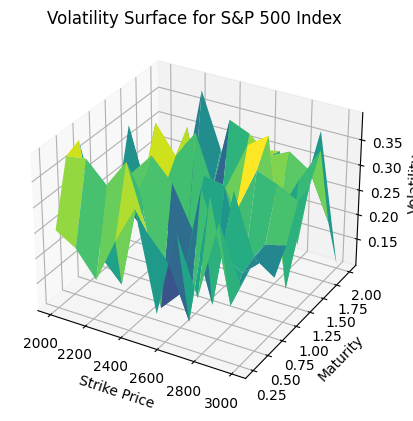

In [ ]:
strike_prices = np.linspace(2000, 3000, 10)  # Example strike prices
maturities = np.linspace(0.25, 2, 10)  # Example maturities
volatility_surface = np.random.rand(len(strike_prices), len(maturities)) * 0.3 + 0.1  # Example volatility data

# Create a meshgrid for strike prices and maturities
X, Y = np.meshgrid(strike_prices, maturities)

# Plot the volatility surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, volatility_surface, cmap='viridis')

# Set labels and title
ax.set_xlabel('Strike Price')
ax.set_ylabel('Maturity')
ax.set_zlabel('Volatility')
ax.set_title('Volatility Surface for S&P 500 Index')

plt.show()

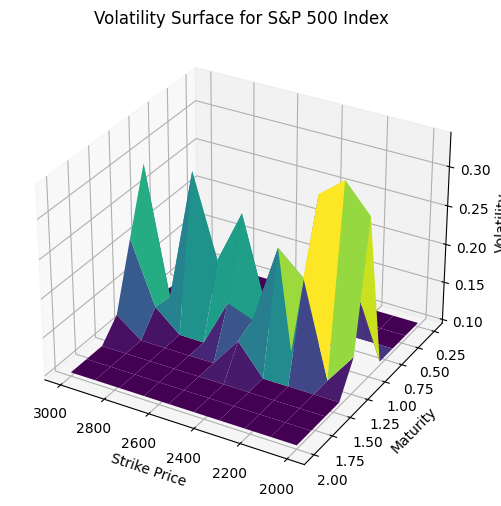

In [ ]:
strike_prices = np.linspace(2000, 3000, 10)
maturities = np.linspace(0.25, 2, 10)

# Generate example volatility surface data
def generate_volatility_surface(strikes, maturities):
    volatility_surface = np.zeros((len(strikes), len(maturities)))
    for i, strike in enumerate(strikes):
        for j, maturity in enumerate(maturities):
            # Example: Volatility smile with higher volatility for at-the-money options
            volatility_surface[i, j] = max(0.1, np.random.normal(0.2, 0.1) - 0.001 * abs(strike - 2500))
    return volatility_surface

volatility_surface = generate_volatility_surface(strike_prices, maturities)

# Create a meshgrid for strike prices and maturities
X, Y = np.meshgrid(strike_prices, maturities)

# Plot the volatility surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, volatility_surface, cmap='viridis')

# Set labels and title
ax.set_xlabel('Strike Price')
ax.set_ylabel('Maturity')
ax.set_zlabel('Volatility')
ax.set_title('Volatility Surface for S&P 500 Index')

# Adjust viewing angle for better visualization
ax.view_init(30, 120)


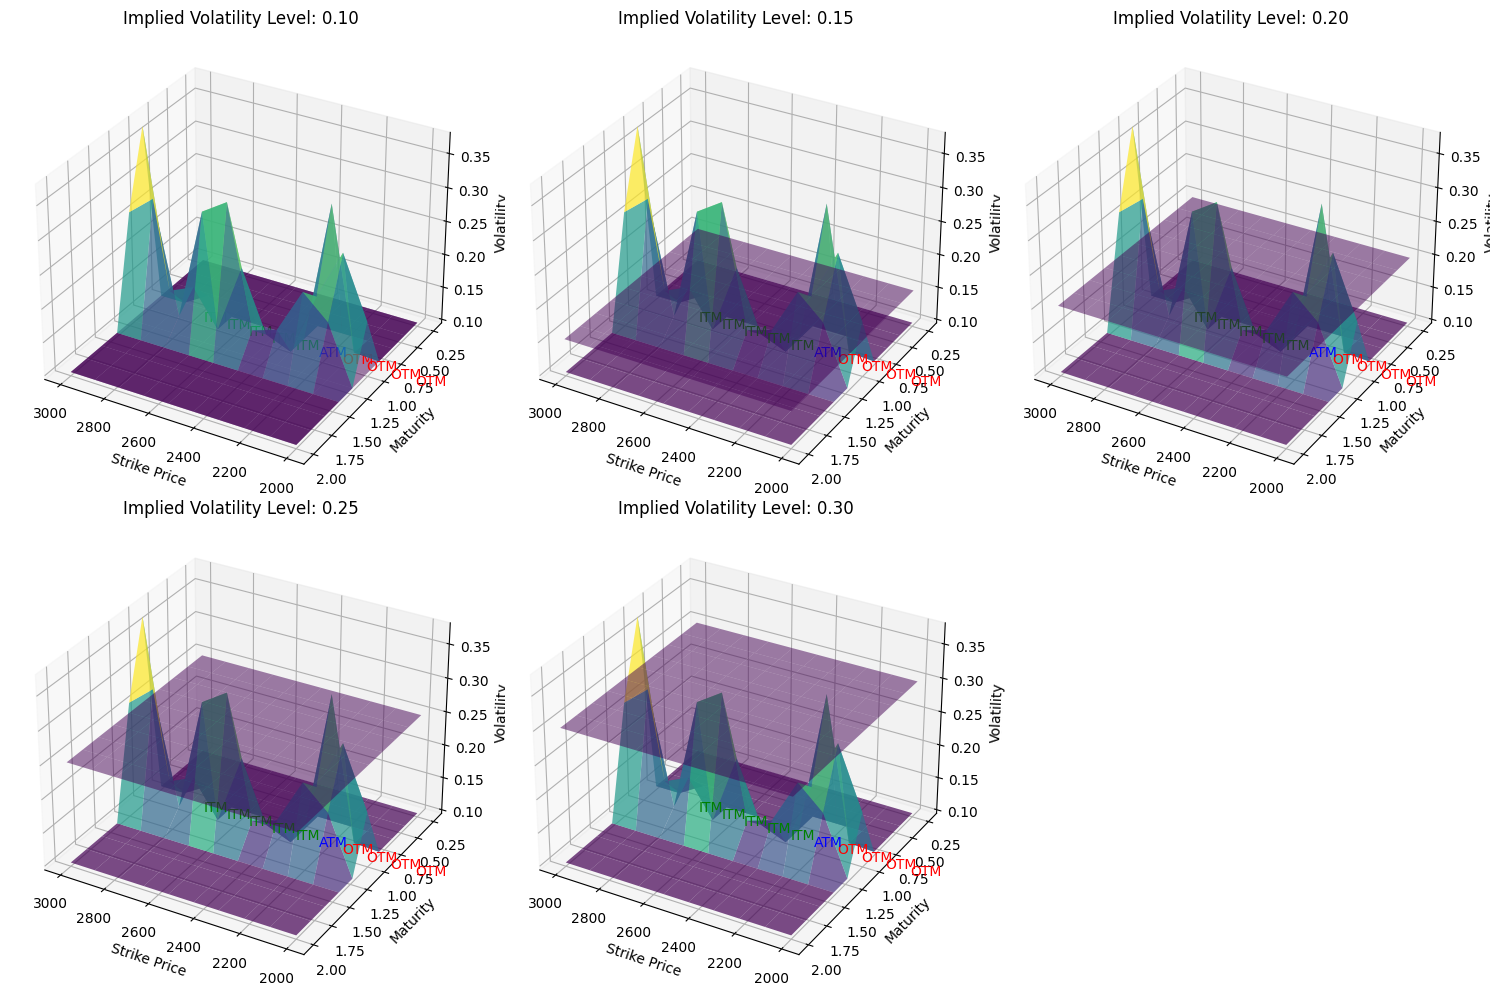

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

strike_prices = np.linspace(2000, 3000, 10)
maturities = np.linspace(0.25, 2, 10)

# Generate example volatility surface data
def generate_volatility_surface(strikes, maturities):
    volatility_surface = np.zeros((len(strikes), len(maturities)))
    for i, strike in enumerate(strikes):
        for j, maturity in enumerate(maturities):
            # Example: Volatility smile with higher volatility for at-the-money options
            volatility_surface[i, j] = max(0.1, np.random.normal(0.2, 0.1) - 0.001 * abs(strike - 2500))
    return volatility_surface

volatility_surface = generate_volatility_surface(strike_prices, maturities)

# Create a meshgrid for strike prices and maturities
X, Y = np.meshgrid(strike_prices, maturities)

# Plot the volatility surface
fig = plt.figure(figsize=(15, 10))

# Plot multiple surfaces with different implied volatilities
for vol_level in np.linspace(0.1, 0.3, 5):
    Z = np.ones_like(volatility_surface) * vol_level
    ax = fig.add_subplot(2, 3, int((vol_level - 0.1) / 0.04) + 1, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)

    # Overlay the original volatility surface
    ax.plot_surface(X, Y, volatility_surface, cmap='viridis', alpha=0.7)

    # Set labels and title
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Maturity')
    ax.set_zlabel('Volatility')
    ax.set_title(f'Implied Volatility Level: {vol_level:.2f}')

    # Add annotations for in the money (ITM), at the money (ATM), and out of the money (OTM)
    atm_strike = strike_prices[np.abs(strike_prices - 2500).argmin()]
    for i in range(len(strike_prices)):
        if strike_prices[i] < atm_strike:
            ax.text(strike_prices[i], maturities[0], 0, 'OTM', color='red')
        elif strike_prices[i] > atm_strike:
            ax.text(strike_prices[i], maturities[0], 0, 'ITM', color='green')
        else:
            ax.text(strike_prices[i], maturities[0], 0, 'ATM', color='blue')

    # Adjust viewing angle for better visualization
    ax.view_init(30, 120)

plt.tight_layout()
plt.show()